In [ ]:
import numpy as np
import zplane as zp     # pip install zplane
import yulewalker as yw # pip install yulewalker 
import matplotlib.pyplot as plt
import scipy.signal as signal

#### Primer 1

In [ ]:
# Na predhodnih vajah smo spoznali možnost filtriranja v frekvenčni domeni
Fs = 1000                       # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 2.56                        # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
freq1 = 10                      # frekvenca 1 [Hz]
freq2 = 20                      # frekvenca 2 [Hz]
A1 = 10.0                       # amplituda 1
A2 = 5.0                        # amplituda 2
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Signali
y1 = A1*np.sin(2*np.pi*freq1*t+p)
y2 = A2*np.sin(2*np.pi*freq2*t+p)

# Seštejemo signala
ys = y1 + y2

# FFT
Yc = np.fft.fft(ys)

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl = 2*abs(Yc[:N//2])

markerline, stemlines, baseline = plt.stem(x, ampl/N, linefmt='blue', markerfmt='o')
markerline.set_markerfacecolor('none')

plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)
plt.xlim(0, 30)
plt.show()

# Kje vidimo težavo?
# Želimo filtriranje v realnem času - FFT ne pride v upoštev - deluje paketno
# Uporabimo nov pristop - digitalno filtriranje

#### Primer 2

In [ ]:
# Glede na definicijo obstaja neskončno mnogo filtrov - filter razdeli signal na zanimivi del in šum.

# Glede na njihovo širšo karakteristiko obstajajo štiri skupine filtov: 
# - nizko sito (low-pass filter)
# - visoko sito (high-pass filter)
# - pasovno prepustno sito (band-pass filter)
# - pasovno zaporno sito (band-stop filter)

f = np.linspace(0, 100, 1000) 

plt.figure(figsize=(10, 6))

# Filter prepušča nižje frekvence in potlači višje
plt.subplot(4, 1, 1)
plt.plot(f, np.where(f <= 50, 1, 0))
plt.title('Nizko sito')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Magnituda')
plt.xticks([]) 
plt.grid()

# Filter prepušča višje frekvence in potlači nižje
plt.subplot(4, 1, 2)
plt.plot(f, np.where(f >= 50, 1, 0))
plt.title('Visoko sito')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Magnituda')
plt.xticks([]) 
plt.grid()

# Filter prepušča samo frekvence v specifičnem pasu
plt.subplot(4, 1, 3)
plt.plot(f, np.where((f >= 25) & (f <= 75), 1, 0))
plt.title('Pasovno prepustno sito')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Magnituda')
plt.xticks([]) 
plt.grid()

# Filter potlači samo frekvence v specifičnem pasu
plt.subplot(4, 1, 4)
plt.plot(f, np.where((f >= 25) & (f <= 75), 0, 1))
plt.title('Pasovno zaporno sito')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Magnituda')
plt.xticks([]) 
plt.grid()

plt.tight_layout()
plt.show()

# Filter z zarezo (notch filter) - ekstremni primer pasovno zapornega sita

# Še nekaj terminov:
# - prepustno območje (pass-band)
# - zaporno območje (stop-band)
# - prehodno območje (transition-band) - pas frekvenc med prepustnim in zapornim območjem
# - lomna frekvenca (cutoff frequency)
# - valovitost (ripple) [dB] - gladkost prepustnega/zapornega območja
# - strmina prehodnega območja (roll-off) [dB/octave] - stopnja zviševanja dušenja frekvenc za lomno frekvenco
# - tolerančna shema
# - dušenje (attenuation) - moč zmanjševanja amplitude v zapornem območju
# - red filtra (filter order) - stopnja aproksimacije polinoma
#                             - povečevanje reda filtra, poveča strmino prehodnega območja in približa filter idealnemu odzivu
# - -3dB - lomna frekvenca pri (-3 dB) - izhodna moč se prepolovi - (10^(3/10) = 0.5)

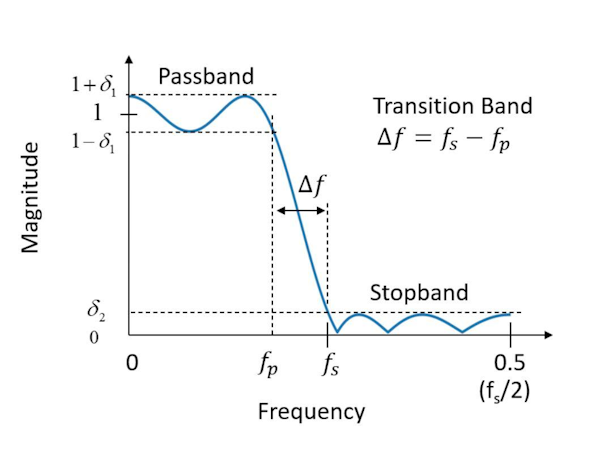

Več: https://documentation.sas.com/doc/en/pgmsascdc/9.4_3.5/casforecast/casforecast_dfil_details03.htm

#### Primer 3

In [ ]:
# Načrtovanje filtrov: IIR ali FIR

# FIR - Finite Impulse Response
# - impulzni odziv ima končno trajanje
# - najpreprostejši FIR filter je povprečenje
# - implementirano s konvolucijo - opis: https://cycling74.com/tutorials/demystifying-digital-filters-part-1
# - imajo linearno fazo, če so njihovi koeficienti simetrični
# - strmina prehodnega območja je odvisna od števila filtrovih koeficientov – več koeficientov, bolj strm prehod
# - idealni filter je tisti, ki ne spremeni frekvenčnih komponent npr. pod lomno frekvenco in odstrani vse komponente nad lomno frekvenco 
# - idealni FIR filter je nemogoče načrtovati, saj je neskončno dolg
# - končni približki neskončnega filtra uvedejo valovitosti v prepustnem in zapornem pasu
# - valovitosti so nezaželene ampak neizogibne

# Načrtujmo FIR filter
Fs = 100                        # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 5.0                         # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
A = 1.0                         # amplituda
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Ustvarimo signal s koraki po 5 Hz
y5 = 0
for f in range (5, 50, 5):
    y5 += A*np.sin(2*np.pi*f*t+p)

# Ustvarimo signal s koraki po 10 Hz
y10 = 0
for f in range (10, 50, 10):
    y10 += A*np.sin(2*np.pi*f*t+p)

# Izris
plt.plot(t, y5)
plt.plot(t, y10)
plt.title(f'Vzor: {Fs} Hz, Frek: 5-50(5) in 10-50(10) Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

In [ ]:
# FFT
Y5 = np.fft.fft(y5)
Y10 = np.fft.fft(y10)

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl5 = 2*abs(Y5[:N//2])
ampl10 = 2*abs(Y10[:N//2])

plt.subplot(2,1,1)
markerline, stemlines, baseline = plt.stem(x, ampl5/N, 'b')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplot(2,1,2)
markerline, stemlines, baseline = plt.stem(x, ampl10/N, 'r')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Iz signala s korakom 5Hz želimo odstranit vmesne frekvence,
# tako da bo rezultat enak signalu s korakom 10Hz

fc = np.array([0])
am = np.array([1])
for f in range(5, 50, 10):
    fc = np.concatenate((fc, [(f-1)/(Fs/2), (f-1)/(Fs/2), (f+1)/(Fs/2), (f+1)/(Fs/2)]))
    am = np.concatenate((am, [           1,            0,            0,            1]))

fc = np.concatenate((fc, [1]))
am = np.concatenate((am, [1]))

# Izris
plt.plot(fc * (Fs/2), am)
plt.title(f'Frekvenčna karakteristika filtra')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Magnituda')
plt.grid(True)
plt.show()

In [ ]:
# Načrtovanje FIR filtra s pomočjo metode najmanjših kvadratičnih pogreškov
# Poskusimo spreminjati red
fo = 21 # Red filtra

taps = signal.firls(fo, fc, am)

# firwin - FIR filter design using the window method
# remez - Calculate the minimax optimal filter using the Remez exchange algorithm

# Matlab
# designfilt - Možnost določitve minimalnega števila koeficientov

# Frekvenčni odziv
w, h = signal.freqz(taps)
fr = w * (Fs/2) / np.pi

fig, ax1 = plt.subplots()
plt.title(f'Frekvenčni odziv')

ax1.plot(fr, 20 * np.log10(np.abs(h)))
ax1.set_ylabel('Ojačanje [dB]')
ax1.set_xlabel('Frekvenca [Hz]')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(fc * (Fs/2), am, color='r')
ax2.set_ylabel('Magnituda')

plt.show()

# Fazni odziv
plt.figure()
plt.plot(fr, np.angle(h))
plt.title('Fazni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Faza [rad]')
plt.grid(True)
plt.show()

In [ ]:
# Metoda filtfilt kompenzira zakasnitev, ki jo uvede filtriranje
y5_fil = signal.filtfilt(taps, 1.0, y10)

# Izris
plt.plot(t, y5_fil)
plt.plot(t, y10)
plt.title(f'Vzor: {Fs} Hz, Frek: 5-50(5) in 10-50(10) Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

# FFT
Y5_fil = np.fft.fft(y5_fil)
Y10 = np.fft.fft(y10)

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl5_fil = 2*abs(Y5_fil[:N//2])
ampl10 = 2*abs(Y10[:N//2])

plt.subplot(2,1,1)
markerline, stemlines, baseline = plt.stem(x, ampl5_fil/N, 'b')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplot(2,1,2)
markerline, stemlines, baseline = plt.stem(x, ampl10/N, 'r')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()

# Kaj lahko ugotovimo?
# - filter mora biti visokega reda, da zagotovi zahtevane karakteristike
# - red filtra raste obratno sorazmerno s širino prehodnega območja
# - počasnejše izvajanje

#### Primer 4

In [ ]:
# IIR - Infinite Impulse Response
# - impulzni odziv ima praviloma neskončno trajanje
# - implementirano z rekurzijo - opis: https://cycling74.com/tutorials/demystifying-digital-filters-part-1
# - filtri imajo praviloma nelinearno fazo
# - strmina prehodnega območja je odvisna od števila filtrovih polov

# Klasični načini načrtovanja filtrov:
# - Butterworth
#   - no gain ripple in pass band and stop band, slow cutoff
# - Chebyshev Type I in Type II
#   - no gain ripple in stop band, moderate cutoff
# - Eliptic
#   - sharpest cutoff (narrowest transition between pass band and stop band) for the given order
# - Bessel

Fs = 100;                 # vzorčevalna frekvenca [Hz]
Fpass = 10/(Fs/2);        # lomna frekvenca (pass-band) [rad/sample]
Ap = 1;                   # pass-band ripple [dB]
Ast = 20;                 # stop-band attenuation [dB]
Fo = 15;                  # red filtra

# Idealni filter
f = np.array([0, Fpass, Fpass, 1]) # Frekvenčne točke
m = np.array([1, 1,     0,     0]) # Ustrezne amplitude

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Chebyshev Type I 
b, a = signal.cheby1(Fo, Ap, Fpass, btype='low')
w, h = signal.freqz(b, a)
fr = w * (Fs/2) / np.pi

axs[0, 0].set_title('Chebyshev Type I')
axs[0, 0].plot(f * (Fs/2), m)
axs[0, 0].plot(fr, np.abs(h))
axs[0, 0].set_xlabel('Frekvenca [Hz]')
axs[0, 0].set_ylabel('Ojačanje')

# Chebyshev Type II 
b, a = signal.cheby2(Fo, Ast, Fpass, btype='low')
w, h = signal.freqz(b, a)
fr = w * (Fs/2) / np.pi

axs[1, 0].set_title('Chebyshev Type II')
axs[1, 0].plot(f * (Fs/2), m)
axs[1, 0].plot(fr, np.abs(h))
axs[1, 0].set_xlabel('Frekvenca [Hz]')
axs[1, 0].set_ylabel('Ojačanje')

# Butterworth 
b, a = signal.butter(Fo, Fpass, btype='low')
w, h = signal.freqz(b, a)
fr = w * (Fs/2) / np.pi

axs[0, 1].set_title('Butterworth')
axs[0, 1].plot(f * (Fs/2), m)
axs[0, 1].plot(fr, np.abs(h))
axs[0, 1].set_xlabel('Frekvenca [Hz]')
axs[0, 1].set_ylabel('Ojačanje')

# Eliptic 
b, a = signal.ellip(Fo, Ap, Ast, Fpass, btype='low')
w, h = signal.freqz(b, a)
fr = w * (Fs/2) / np.pi

axs[1, 1].set_title('Eliptic')
axs[1, 1].plot(f * (Fs/2), m)
axs[1, 1].plot(fr, np.abs(h))
axs[1, 1].set_xlabel('Frekvenca [Hz]')
axs[1, 1].set_ylabel('Ojačanje')

plt.subplots_adjust(hspace=0.3)
plt.show()

#### Primer 5

In [ ]:
# Načrtujmo IIR filtre
Fs = 100;                             # vzorčevalna frekvenca [Hz]
Fpass_bu = 13/(Fs/2);                 # lomna frekvenca [rad/sample]
Fpass_ch = np.array([13, 17])/(Fs/2); # lomna frekvenca (pass-band) [rad/sample]
Fpass_el = 17/(Fs/2);                 # lomna frekvenca [rad/sample]
Ap = 1;                               # pass-band ripple [dB]
Ast = 60;                             # stop-band attenuation [dB]
                                                        
# Načrtujmo nekaj filtrov
bu_b, bu_a = signal.butter(5, Fpass_bu, 'low')
ch_b, ch_a = signal.cheby2(5, Ast, Fpass_ch, 'stop')
el_b, el_a = signal.ellip(5, Ap, Ast, Fpass_el, 'high')
                              
# Uporabimo filtre
Fs = 100                        # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 5.0                         # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
freq1 = 10                      # frekvenca 1
freq2 = 15                      # frekvenca 2
freq3 = 20                      # frekvenca 3
A = 1.0                         # amplituda
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Ustvarimo signal s koraki po 5 Hz
y = A*np.sin(2*np.pi*freq1*t+p) + A*np.sin(2*np.pi*freq2*t+p) + A*np.sin(2*np.pi*freq3*t+p)

# Izris
plt.plot(t, y)
plt.title(f'Vzor: {Fs} Hz, Frek: 5-20(5) Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

In [ ]:
# FFT
Y = np.fft.fft(y)

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl = 2*abs(Y[:N//2])

plt.figure()
markerline, stemlines, baseline = plt.stem(x, ampl/N, 'b')
markerline.set_markerfacecolor('none')

plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

In [ ]:
# Butterworth - Low pass

# FFT
Y = np.fft.fft(signal.filtfilt(bu_b, bu_a, y))

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl = 2*abs(Y[:N//2])

plt.figure()

# Frekvenčni odziv
w, h = signal.freqz(bu_b, bu_a)
fr = w * (Fs/2) / np.pi

plt.subplot(3,1,1)
plt.plot(fr, 20 * np.log10(np.abs(h)), 'b')
plt.title(f'Frekvenčni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Ojačanje [dB]')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(fr, np.angle(h), 'b')
plt.title(f'Fazni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Faza [rad]')
plt.grid(True)

plt.subplot(3,1,3)
markerline, stemlines, baseline = plt.stem(x, ampl/N, 'b')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplots_adjust(hspace=1.0)
plt.show()

In [ ]:
# Chebyshev Type II - Band stop

# FFT
Y = np.fft.fft(signal.filtfilt(ch_b, ch_a, y))

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl = 2*abs(Y[:N//2])

plt.figure()

# Frekvenčni odziv
w, h = signal.freqz(ch_b, ch_a)
fr = w * (Fs/2) / np.pi

plt.subplot(3,1,1)
plt.plot(fr, 20 * np.log10(np.abs(h)), 'b')
plt.title(f'Frekvenčni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Ojačanje [dB]')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(fr, np.angle(h), 'b')
plt.title(f'Fazni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Faza [rad]')
plt.grid(True)

plt.subplot(3,1,3)
markerline, stemlines, baseline = plt.stem(x, ampl/N, 'b')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplots_adjust(hspace=1.0)
plt.show()

In [ ]:
# Eliptic - High pass

# FFT
Y = np.fft.fft(signal.filtfilt(el_b, el_a, y))

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl = 2*abs(Y[:N//2])

plt.figure()

# Frekvenčni odziv
w, h = signal.freqz(el_b, el_a)
fr = w * (Fs/2) / np.pi

plt.subplot(3,1,1)
plt.plot(fr, 20 * np.log10(np.abs(h)), 'b')
plt.title(f'Frekvenčni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Ojačanje [dB]')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(fr, np.angle(h), 'b')
plt.title(f'Fazni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Faza [rad]')
plt.grid(True)

plt.subplot(3,1,3)
markerline, stemlines, baseline = plt.stem(x, ampl/N, 'b')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplots_adjust(hspace=1.0)
plt.show()

#### Primer 6

In [ ]:
# Primer kompleksnejšega IIR filtra
Fs = 100                        # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 5.0                         # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
A = 1.0                         # amplituda
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Ustvarimo signal s koraki po 5 Hz
y5 = 0
for f in range (5, 50, 5):
    y5 += A*np.sin(2*np.pi*f*t+p)

# Ustvarimo signal s koraki po 10 Hz
y10 = 0
for f in range (10, 50, 10):
    y10 += A*np.sin(2*np.pi*f*t+p)

# Izris
plt.plot(t, y5)
plt.plot(t, y10)
plt.title(f'Vzor: {Fs} Hz, Frek: 5-50(5) in 10-50(10) Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

In [ ]:
# FFT
Y5 = np.fft.fft(y5)
Y10 = np.fft.fft(y10)

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl5 = 2*abs(Y5[:N//2])
ampl10 = 2*abs(Y10[:N//2])

plt.subplot(2,1,1)
markerline, stemlines, baseline = plt.stem(x, ampl5/N, 'b')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplot(2,1,2)
markerline, stemlines, baseline = plt.stem(x, ampl10/N, 'r')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Iz signala s korakom 5Hz želimo odstranit vmesne frekvence,
# tako da bo rezultat enak signalu s korakom 10Hz

fc = np.array([0])
am = np.array([1])
for f in range(5, 50, 10):
    fc = np.concatenate((fc, [(f-1)/(Fs/2), (f-1)/(Fs/2), (f+1)/(Fs/2), (f+1)/(Fs/2)]))
    am = np.concatenate((am, [           1,            0,            0,            1]))

fc = np.concatenate((fc, [1]))
am = np.concatenate((am, [1]))

# Izris
plt.plot(fc * (Fs/2), am)
plt.title(f'Frekvenčna karakteristika filtra')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Magnituda')
plt.grid(True)
plt.show()

In [ ]:
# Načrtovanje IIR filtra z Yule-Walkerjevim reševanjem sistema enačb
fo = 25 # Red filtra

# Nastavitev np.int zaradi stare različice NumPy
# Pozor: funkcija vrača a,b in ne b,a!
np.int = np.int64
a, b = yw.yulewalk(fo, fc, am)

# Frekvenčni odziv
w, h = signal.freqz(b, a)
fr = w * (Fs/2) / np.pi

fig, ax1 = plt.subplots()
plt.title(f'Frekvenčni odziv')

ax1.plot(fr, 20 * np.log10(np.abs(h)))
ax1.set_ylabel('Ojačanje [dB]')
ax1.set_xlabel('Frekvenca [Hz]')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(fc * (Fs/2), am, color='r')
ax2.set_ylabel('Magnituda')

plt.show()

# Fazni odziv
plt.figure()
plt.plot(fr, np.angle(h))
plt.title('Fazni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Faza [rad]')
plt.grid(True)
plt.show()

In [ ]:
# Metoda filtfilt kompenzira zakasnitev, ki jo uvede filtriranje
y5_fil = signal.filtfilt(b, a, y10)

# Izris
plt.plot(t, y5_fil)
plt.plot(t, y10)
plt.title(f'Vzor: {Fs} Hz, Frek: 5-50(5) in 10-50(10) Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

# FFT
Y5_fil = np.fft.fft(y5_fil)
Y10 = np.fft.fft(y10)

# Frekvenčni razdelki za risanje X osi
x = np.linspace(0, Fs/2, N//2)

# Amplitude
ampl5_fil = 2*abs(Y5_fil[:N//2])
ampl10 = 2*abs(Y10[:N//2])

plt.subplot(2,1,1)
markerline, stemlines, baseline = plt.stem(x, ampl5_fil/N, 'b')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplot(2,1,2)
markerline, stemlines, baseline = plt.stem(x, ampl10/N, 'r')
markerline.set_markerfacecolor('none')
plt.title(f'Frekvenčna vsebina')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Amplituda')
plt.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()

#### Primer 7

In [ ]:
# Stabilnost IIR filtrov
# IIR filter je stabilen, če vsi poli ležijo znotraj enotske krožnice v z-ravnini

Fs = 100;          # vzorčevalna frekvenca [Hz]
Fpass = 25/(Fs/2); # lomna frekvenca (pass-band) [rad/sample]

b, a = signal.butter(5, Fpass, "high")
tf = signal.TransferFunction(b, a, dt=1/Fs)

# Izris
zp.pz(tf)

# Matlab: funkcija isstable
# Ali je spodnji zapis OK?
print(f"Stable: {np.all(np.abs(np.roots(a)) < 1)}")

# Kaj lahko ugotovimo?
# - hitrejše izvajanje ampak slabša učinkovitost kot pri FIR
# - potrebujemo manj koeficientov kot pa pri FIR filtrih
# - težave s stabilnostjo; FIR filtri so vedno stabilni
# - problem nelinearnosti; FIR filtri lahko vedno zagotovijo linearnost

#### Primer 8

In [ ]:
# Kako lahko izboljšamo stabilnost IIR filtrov?
Fs = 100                        # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 5.0                         # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
freq1 = 10                      # frekvenca 1
freq2 = 15                      # frekvenca 2
freq3 = 20                      # frekvenca 3
A = 1.0                         # amplituda
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Ustvarimo signal
y_comp = A*np.sin(2*np.pi*freq2*t+p)
y = A*np.sin(2*np.pi*freq1*t+p) + A*np.sin(2*np.pi*freq3*t+p) + y_comp

# Izris
plt.plot(t, y)
plt.title(f'Vzor: {Fs} Hz, Frek: {freq1}, {freq2} in {freq3} Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

In [ ]:
# Ustvarimo filtre
# z,p,k - Zeros, poles, and system gain of the IIR filter transfer function
# b,a - Numerator (b) and denominator (a) polynomials of the IIR filter
# sos - Second-order sections representation of the IIR filter
cut_low = (freq2-1)/(Fs/2)
cut_high = (freq2+1)/(Fs/2)

# b, a
b, a = signal.butter(50, [cut_low, cut_high], btype="bandpass")

# Frekvenčni odziv
w, h = signal.freqz(b, a)
fr = w * (Fs/2) / np.pi

plt.figure()
plt.plot(fr, np.abs(h), 'b')
plt.title(f'Frekvenčni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Ojačanje')
plt.grid(True)

# sos
# Pretvorba v second-order-sections
# Višje redni filter pretvorimo v serijo biquad filtrov (bi-kvadratni filtri imajo dva pola in dve ničli)
sos = signal.butter(50, [cut_low, cut_high], btype='bandpass', output='sos')

# Frekvenčni odziv
w, h = signal.freqz_sos(sos)
fr = w * (Fs/2) / np.pi

plt.figure()
plt.plot(fr, np.abs(h), 'b')
plt.title(f'Frekvenčni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Ojačanje')
plt.grid(True)

# Uporabimo filter
y_sos = signal.sosfiltfilt(sos, y)

# Izris
plt.figure()
plt.plot(t, y_comp, 'b')
plt.plot(t, y_sos, 'r')
plt.title(f'Vzor: {Fs} Hz, Frek: {freq2} Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

#### Primer 9

In [ ]:
# Kaskada filtrov
# Nadomestimo kompleksen filter s kaskado filtrov, ki zaporedno obravnava
# vhodni signal. Izhod predhodnega filtra je vhod v naslednjega.
Fs = 100                        # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 5.0                         # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
freq1 = 10                      # frekvenca 1
freq2 = 15                      # frekvenca 2
freq3 = 20                      # frekvenca 3
A = 1.0                         # amplituda
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Ustvarimo signal
y_comp = A*np.sin(2*np.pi*freq2*t+p)
y = A*np.sin(2*np.pi*freq1*t+p) + A*np.sin(2*np.pi*freq3*t+p) + y_comp

# Izris
plt.plot(t, y)
plt.title(f'Vzor: {Fs} Hz, Frek: {freq1}, {freq2} in {freq3} Hz, Ampl: {A}, Faza: {p} rad')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.xlim([0, 1])
plt.grid(True)
plt.show()

# Načrtujmo kaskado filtrov, da ohranimo samo 15Hz
# Kakšno vrsto filtra rabimo in kako izgleda?
b_l, a_l = signal.butter(8, (freq2+1)/(Fs/2), btype="low")
b_h, a_h = signal.butter(8, (freq2-1)/(Fs/2), btype="high")

# Frekvenčni odziv
w_l, h_l = signal.freqz(b_l, a_l)
fr_l = w_l * (Fs/2) / np.pi

w_h, h_h = signal.freqz(b_h, a_h)
fr_h = w_h * (Fs/2) / np.pi

plt.figure()
plt.plot(fr_l, np.abs(h_l), 'b')
plt.plot(fr_h, np.abs(h_h), 'r')
plt.title(f'Frekvenčni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Ojačanje')
plt.grid(True)

# Združena odziva
h_c = h_l * h_h

plt.figure()
plt.plot(fr_l, np.abs(h_c), 'b')
plt.title(f'Frekvenčni odziv')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('Ojačanje')
plt.grid(True)

#### Primer 10

In [ ]:
# Savitzky–Golay filter
# Smoothing filter used to reduce noise while preserving the shape and features of a signal 
Fs = 100                        # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 1.0                         # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
freq = 5                        # frekvenca
A = 1.0                         # amplituda
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Ustvarimo signal
y = A*np.sin(2*np.pi*freq*t+p)

# Dodamo šum
noise = 0.3 * np.random.normal(size=y.shape)
y_noisy = y + noise

# Uporabimo Savitzky–Golay filter
y_filtered = signal.savgol_filter(y_noisy, window_length=31, polyorder=9)

# Izris
plt.plot(t, y_noisy)
plt.plot(t, y_filtered, 'r')
plt.plot(t, y, linestyle='--', color='k')
plt.title(f'Savitzky–Golay filter')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()

#### Primer 11

In [ ]:
# Weiner filter
# It works well when the signal is corrupted by additive Gaussian noise
Fs = 100                        # vzorčevalna frekvenca [Hz] - število "točk" na sekundo
T = 1.0                         # dolžina vzorcev - signala [s]
t = np.arange(0, T, (1.0 / Fs)) # točke vzorčenja - časovni vektor
freq = 5                        # frekvenca
A = 1.0                         # amplituda
p = 0.0                         # faza [rad]
N = len(t)                      # število vzorcev v signalu

# Ustvarimo signal
y = A*np.sin(2*np.pi*freq*t+p)

# Dodamo šum
noise = 0.5 * np.random.normal(size=y.shape)
y_noisy = y + noise

# Uporabimo Wiener filter
y_filtered = signal.wiener(y_noisy, mysize=7)

# Izris
plt.plot(t, y_noisy)
plt.plot(t, y_filtered, 'r')
plt.plot(t, y, linestyle='--', color='k')
plt.title(f'Wiener filter')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()